##### Homework #4
##### Nazmul Rabbi
##### 10/17/2024

In [1]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read the data
df = pd.read_csv('bank-full.csv', delimiter=';')

# see the first 5 rows of the data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# drop the columns 'default' and 'loan'
df = df.drop(['default', 'loan'], axis=1)

# see the first 5 rows of the data
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# convert target variable 'y' to binary
df['y'] = df['y'].map({'no': 0, 'yes' : 1})

In [5]:
# split the data into train, validation and test sets
train_data, temp_data = train_test_split(df, test_size=0.4, random_state=1)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1)

# drop and sepearte the target variable as well as reset the index
X_train = train_data.drop(columns=['y']).reset_index(drop=True)
y_train = train_data['y'].reset_index(drop=True)
X_val = val_data.drop(columns=['y']).reset_index(drop=True)
y_val = val_data['y'].reset_index(drop=True)
X_test = test_data.drop(columns=['y']).reset_index(drop=True)
y_test = test_data['y'].reset_index(drop=True)

In [6]:
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
roc_scores = {}

for col in numerical_columns:
    score = roc_auc_score(y_train, X_train[col])
    if score < 0.5: score = roc_auc_score(y_train, -X_train[col])
    roc_scores[col] = score 

roc_scores

{'age': np.float64(0.5125105881599707),
 'balance': np.float64(0.5916931412945473),
 'day': np.float64(0.5291275984648961),
 'duration': np.float64(0.8128648066681694),
 'campaign': np.float64(0.5742447701740003),
 'pdays': np.float64(0.5897967289320412),
 'previous': np.float64(0.5986704105715122)}

In [7]:
print("Q1: Highest feature AUC is" , max(roc_scores, key=roc_scores.get))

Q1: Highest feature AUC is duration


In [8]:
# convert the data into dictionary
train_dict = X_train.to_dict(orient='records')

# initialize DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dict)

# train the model using the training data
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# prepare validation data
val_dict = X_val.to_dict(orient='records')
X_val_encoded = dv.transform(val_dict)

# predict on the validation data
y_pred = model.predict_proba(X_val_encoded)[:, 1] # probability of the positive class

# calculate the roc auc score
auc_score = roc_auc_score(y_val, y_pred)

In [9]:
print(f"Q2: Validation AUC is {auc_score:.3f}")

Q2: Validation AUC is 0.900


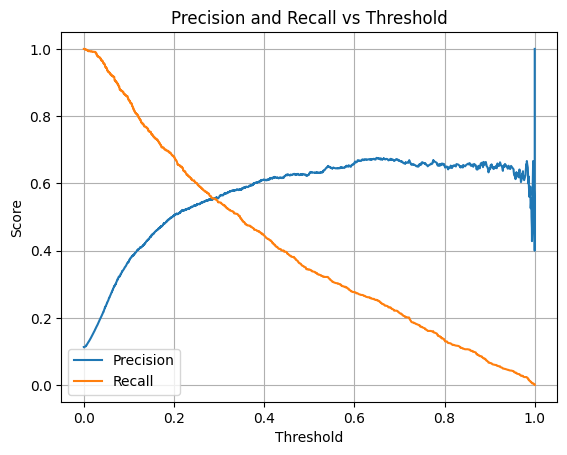

In [10]:
# calculate the precision and recall
precision, recall, threshold = precision_recall_curve(y_val, y_pred)

# plot the precision and recall vs threshold
plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall vs Threshold')
plt.grid()
plt.show()

# find the threshold for which precision and recall intersect
intersection_idx = np.argmin(np.abs(precision - recall))
intersection_threshold = threshold[intersection_idx]

In [11]:
print(f"Q3: Precision & Recall intersect at threshold {intersection_threshold:.3f}")

Q3: Precision & Recall intersect at threshold 0.289


In [12]:
# generate the threshold list
threshold_list = np.arange(0, 1, 0.01)
f1_scores = []

# calculate the f1 score for each threshold
for threshold in threshold_list:
    y_pred_thresh = (y_pred >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_thresh)
    f1_scores.append(f1)

# find the threshold for which f1 score is maximum
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = threshold_list[max_f1_idx]


In [13]:
print("Q4: Maximal F1 Threshold is", max_f1_threshold)

Q4: Maximal F1 Threshold is 0.2


In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(train_data):
    train_fold = train_data.iloc[train_idx]
    val_fold = train_data.iloc[val_idx]

    # Use preprocessed features from previous steps
    X_train_fold_data = train_fold.drop(columns=['y']).reset_index(drop=True)
    y_train_fold_data = train_fold['y'].reset_index(drop=True)
    X_val_fold_data = val_fold.drop(columns=['y']).reset_index(drop=True)
    y_val_fold_data = val_fold['y'].reset_index(drop=True)

    # Transform features using already fitted DictVectorizer
    train_dict = X_train_fold_data.to_dict(orient='records')
    val_dict = X_val_fold_data.to_dict(orient='records')
    X_train_encoded = dv.transform(train_dict)
    X_val_encoded = dv.transform(val_dict)

    # Fit the model using the same logistic regression object
    model.fit(X_train_encoded, y_train_fold_data)
    
    # Predict probabilities
    y_pred = model.predict_proba(X_val_encoded)[:, 1]
    
    # Calculate AUC score
    auc = roc_auc_score(y_val_fold_data, y_pred)
    auc_scores.append(auc)

# Standard deviation of AUC scores
auc_std = np.std(auc_scores)

In [15]:
print(f"Q5: Standard Deviation for 5 fold CV {auc_std:.3f}")

Q5: Standard Deviation for 5 fold CV 0.004


In [16]:
C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)
mean_scores = []
std_scores = []

for C in C_values:
    auc_scores_C = []
    for train_idx, val_idx in kf.split(train_data):
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]

        # Use preprocessed features from previous steps
        X_train_fold_data = train_fold.drop(columns=['y']).reset_index(drop=True)
        y_train_fold_data = train_fold['y'].reset_index(drop=True)
        X_val_fold_data = val_fold.drop(columns=['y']).reset_index(drop=True)
        y_val_fold_data = val_fold['y'].reset_index(drop=True)

        # Transform features using already fitted DictVectorizer
        train_dict = X_train_fold_data.to_dict(orient='records')
        val_dict = X_val_fold_data.to_dict(orient='records')
        X_train_encoded = dv.transform(train_dict)
        X_val_encoded = dv.transform(val_dict)

        # Logistic Regression model with given C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded, y_train_fold_data)
        
        # Predict probabilities
        y_pred = model.predict_proba(X_val_encoded)[:, 1]
        
        # Calculate AUC score
        auc = roc_auc_score(y_val_fold_data, y_pred)
        auc_scores_C.append(auc)

    # Calculate mean and standard deviation for current C
    mean_score = np.mean(auc_scores_C)
    std_score = np.std(auc_scores_C)
    mean_scores.append(float(mean_score))
    std_scores.append(float(std_score))

# Find the best C value 
best_idx = np.argmax(mean_scores)
best_C = C_values[best_idx]

print(f"Mean AUC scores for each C: {mean_scores}")
print(f"Standard deviation of AUC scores for each C: {std_scores}")

Mean AUC scores for each C: [0.6960150133959339, 0.8540734580041697, 0.9077493857605594]
Standard deviation of AUC scores for each C: [0.007741748794784924, 0.005574503602056373, 0.004069901272477149]


In [17]:
print(f"Q6: Best C value is {C_values[best_idx]}")

Q6: Best C value is 1
